U.S. Economic Indicator Analysis

Part 1: Data Acquisition, Cleaning, and Transformation
This script serves as the complete data preparation pipeline for the project. It performs the following steps:

Initializes Libraries: Imports all necessary Python libraries (Pandas, FredAPI, etc.) and sets up the FRED API connection.
Fetches API Data: Programmatically pulls 7 key time-series data series from the Federal Reserve Economic Data (FRED) database.
Loads Manual Data: Loads and cleans two manually created CSV files containing historical data not available on FRED:
CEO-to-worker pay ratio data from the Economic Policy Institute (EPI).
Union membership density data from unionstats.com.
Merges Data Sources: Combines the data from all three sources into a single, unified DataFrame.
Final Cleaning Workflow: Executes a robust cleaning process by converting all columns to a numeric format and then dropping any rows with missing data to create a final, analysis-ready dataset starting from the first year where all indicators are present.

In [34]:
# ==============================================================================
# CELL 1: MASTER DATA PREPARATION SCRIPT
# This script handles all steps: Data Acquisition, Cleaning, and Transformation
# ==============================================================================

# --- PART 1: ACQUISITION & CLEANING ---
print("--- Initializing ---")
# Import necessary libraries
import pandas as pd
from fredapi import Fred
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Install fredapi if not already installed
!pip install fredapi -q

# Initialize the FRED API with your key
# IMPORTANT: Replace 'YOUR_API_KEY_HERE' with your actual 32-character key
api_key = '7a8306ce9903fb201e2755c1b92238da'
fred = Fred(api_key=api_key)

# Define the FINAL list of 7 FRED series IDs
fred_series_ids = {
    'corporate_profits': 'CP', 'gdp': 'GDP', 'nonsupervisory_wage': 'AHETPI',
    'gdp_per_capita': 'A939RC0A052NBEA', 'gini_ratio': 'GINIALLRH',
    'median_family_income': 'MEFAINUSA672N', 'cpi': 'CPIAUCSL'
}

# Fetch data from FRED
fred_data_frames = {}
print("\n--- Fetching Final Data Series from FRED API ---")
for name, series_id in fred_series_ids.items():
    fred_data_frames[name] = fred.get_series(series_id).to_frame(name=name)
print("Successfully processed FRED data.")

# Resample and combine FRED data
annual_fred_frames = []
for name, df in fred_data_frames.items():
    annual_df = df.resample('YE').mean()
    annual_fred_frames.append(annual_df)
fred_df = pd.concat(annual_fred_frames, axis=1)
fred_df.index = fred_df.index.year

# Load and clean the manual EPI data
print("\n--- Loading and cleaning manually created EPI data ---")
try:
    messy_epi_df = pd.read_csv('EPI CEO Pay .csv', header=None)
    header_row_index = messy_epi_df[messy_epi_df[0].str.contains('year', case=False, na=False)].index[0]
    epi_df = messy_epi_df.iloc[header_row_index:].copy()
    epi_df.columns = epi_df.iloc[0]
    epi_df = epi_df[1:]
    epi_df['year'] = pd.to_numeric(epi_df['year'], errors='coerce')
    epi_df.dropna(subset=['year'], inplace=True)
    epi_df.set_index('year', inplace=True)
    print("Successfully loaded and cleaned EPI data.")
except FileNotFoundError:
    print("ERROR: 'EPI CEO Pay .csv' not found. Please upload the file.")
except Exception as e:
    print(f"An error occurred while loading EPI data: {e}")

# Load and clean the manual Union Stats data
print("\n--- Loading and cleaning manually created Union Stats data ---")
try:
    raw_union_df = pd.read_csv('union_membership.csv', header=1)
    union_df = raw_union_df.iloc[:, [0, 5]].copy()
    union_df.columns = ['Year', 'Union_Density']
    union_df['Year'] = pd.to_numeric(union_df['Year'], errors='coerce')
    union_df.dropna(subset=['Year'], inplace=True)
    union_df['Union_Density'] = pd.to_numeric(union_df['Union_Density'].astype(str).str.replace('%', ''), errors='coerce')
    union_df.dropna(subset=['Union_Density'], inplace=True)
    union_df['Union_Density'] = union_df['Union_Density'] / 100.0
    union_df.set_index('Year', inplace=True)
    print("Successfully loaded and cleaned Union Stats data.")
except FileNotFoundError:
    print("ERROR: 'union_membership.csv' not found. Please upload the file.")
except Exception as e:
    print(f"An error occurred while loading Union Stats data: {e}")


# Merge all three data sources
combined_df_1 = fred_df.join(epi_df, how='outer')
combined_df_final = combined_df_1.join(union_df, how='outer')
print("\n--- Successfully Merged All Data Sources ---")

# Final Cleaning Workflow
for col in combined_df_final.columns:
    combined_df_final[col] = pd.to_numeric(combined_df_final[col], errors='coerce')
df_cleaned = combined_df_final.dropna()
print("\nFinal clean dataset created.")


# --- PART 2: DATA TRANSFORMATION ---
print("\n--- Performing Final Data Transformation ---")
plot_df = pd.DataFrame(index=df_cleaned.index)
base_year = 2023
base_cpi = df_cleaned.loc[base_year, 'cpi']
columns_to_adjust = ['corporate_profits', 'gdp', 'nonsupervisory_wage']
for col in columns_to_adjust:
    plot_df[f'Real {col.replace("_", " ").title()}'] = df_cleaned[col] / (df_cleaned['cpi'] / base_cpi)
plot_df['Real GDP/Capita'] = df_cleaned['gdp_per_capita']
plot_df['Real Median Family Income'] = df_cleaned['median_family_income']
plot_df['Gini Ratio'] = df_cleaned['gini_ratio']
plot_df['CEO-Worker Pay Ratio'] = df_cleaned['Realized CEO compensation']
plot_df['Union Density'] = df_cleaned['Union_Density']
print("Final analysis DataFrame (plot_df) created successfully.")

print("\n--- SETUP COMPLETE: The 'plot_df' DataFrame is ready for analysis. ---")

--- Initializing ---

--- Fetching Final Data Series from FRED API ---
Successfully processed FRED data.

--- Loading and cleaning manually created EPI data ---
Successfully loaded and cleaned EPI data.

--- Loading and cleaning manually created Union Stats data ---
Successfully loaded and cleaned Union Stats data.

--- Successfully Merged All Data Sources ---

Final clean dataset created.

--- Performing Final Data Transformation ---
Final analysis DataFrame (plot_df) created successfully.

--- SETUP COMPLETE: The 'plot_df' DataFrame is ready for analysis. ---


Part 2: Exploratory Data Analysis & Visualization

This script uses the final, cleaned plot_df DataFrame to conduct a comprehensive exploratory data analysis. The goal is to visualize the relationships between the key economic indicators to identify trends and structural shifts.

The script generates a full suite of visualizations:

A Correlation Heatmap: To provide a high-level quantitative summary of all relationships.
Color-Coded Scatter Plots: To visualize the chronological path of key variable pairs over time.
Rolling Correlation Plots: To analyze how the strength and direction of these relationships have evolved over different decades.
An Indexed Growth Chart: To serve as a capstone visual, comparing the relative growth of different economic components from a common starting point.


--- Generating All 12 Final Visualizations ---

--- 1. Correlation Heatmap ---


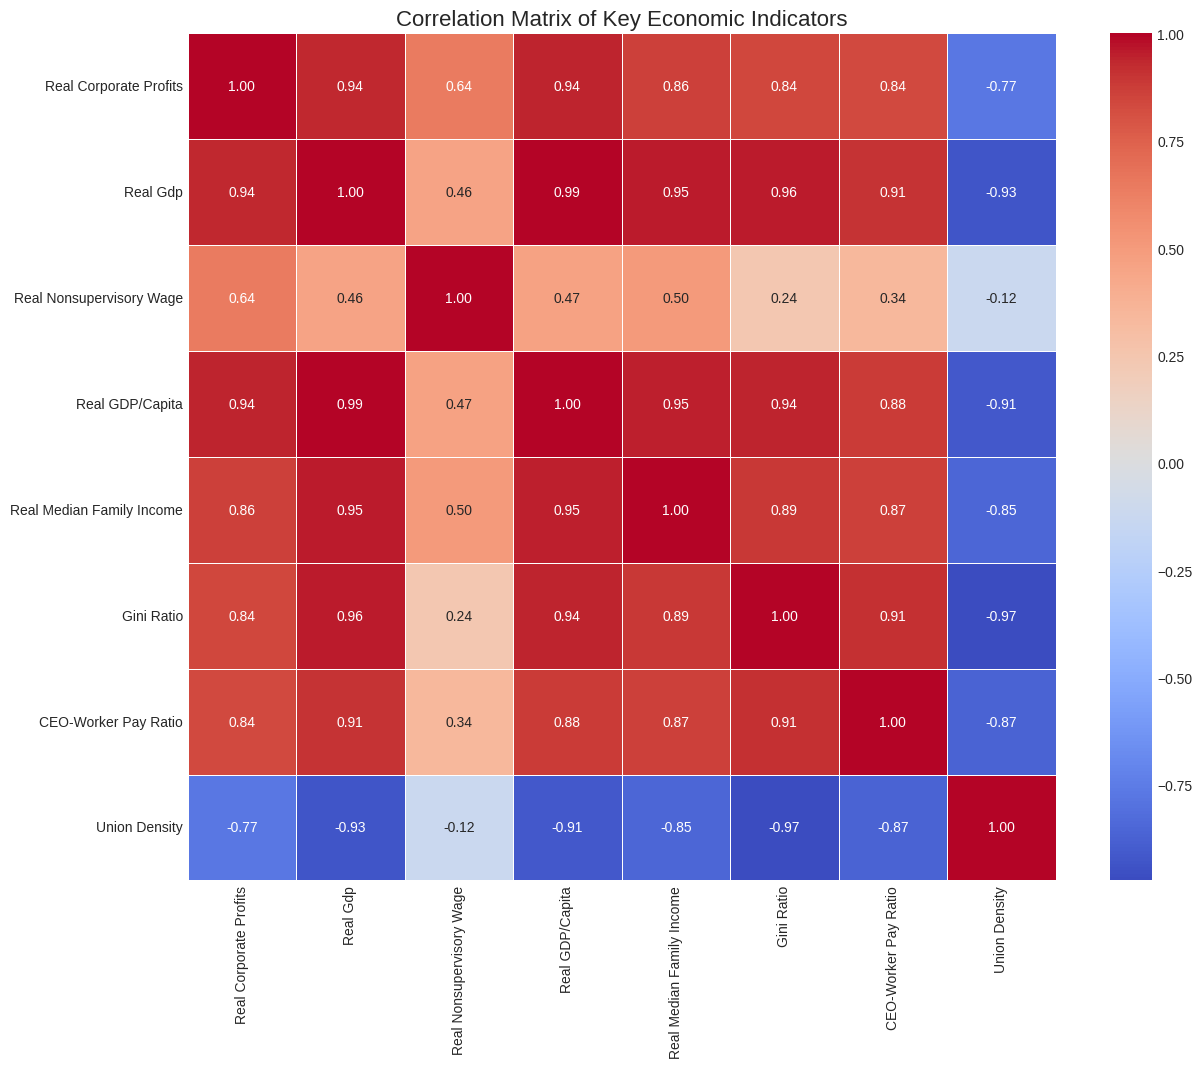


--- 2. Union Density vs. CEO Pay Ratio ---


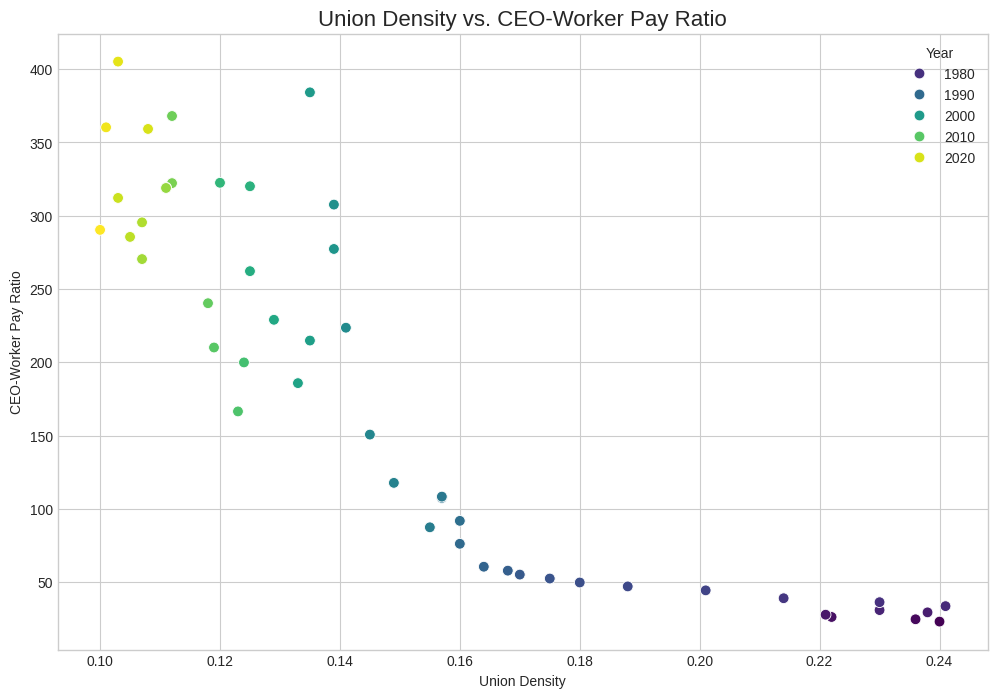

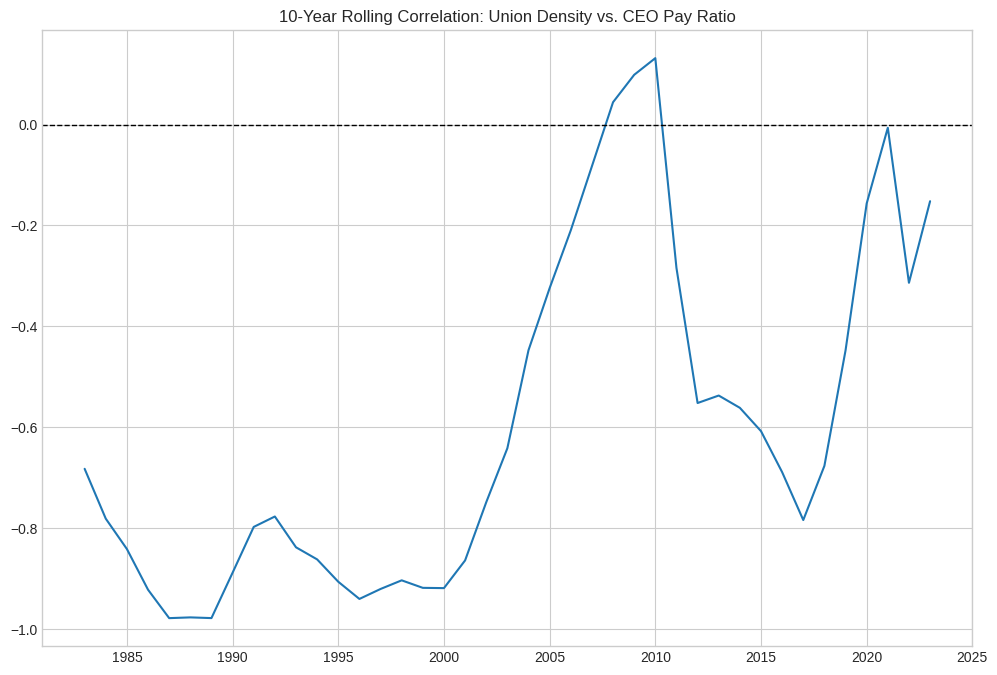


--- 3. Real Gdp vs. Real Corporate Profits ---


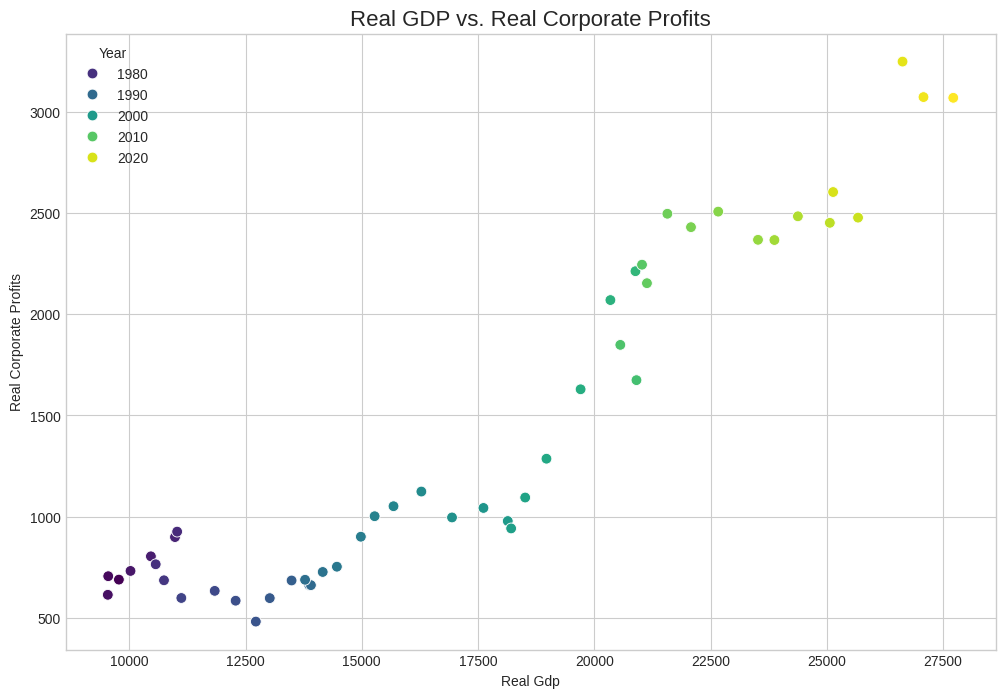

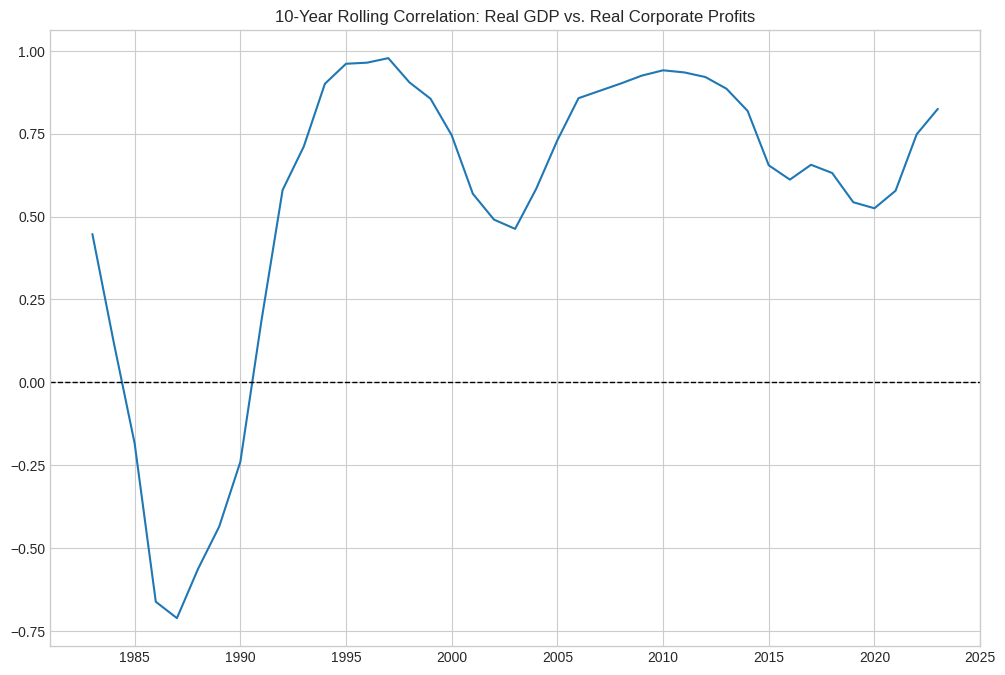


--- 4. Gini Ratio vs. Real Corporate Profits ---


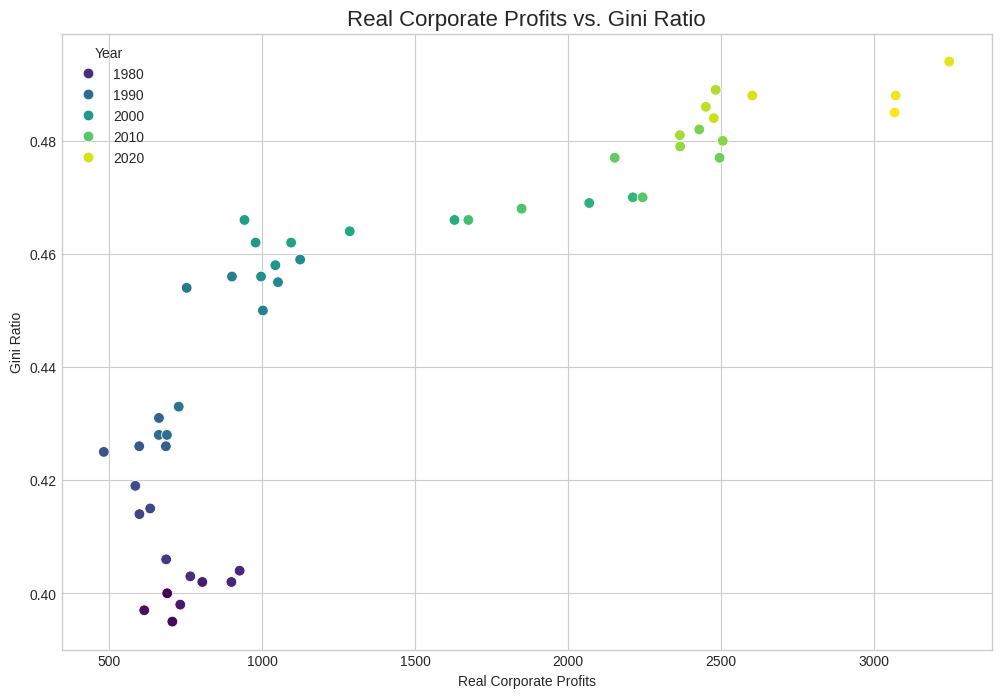

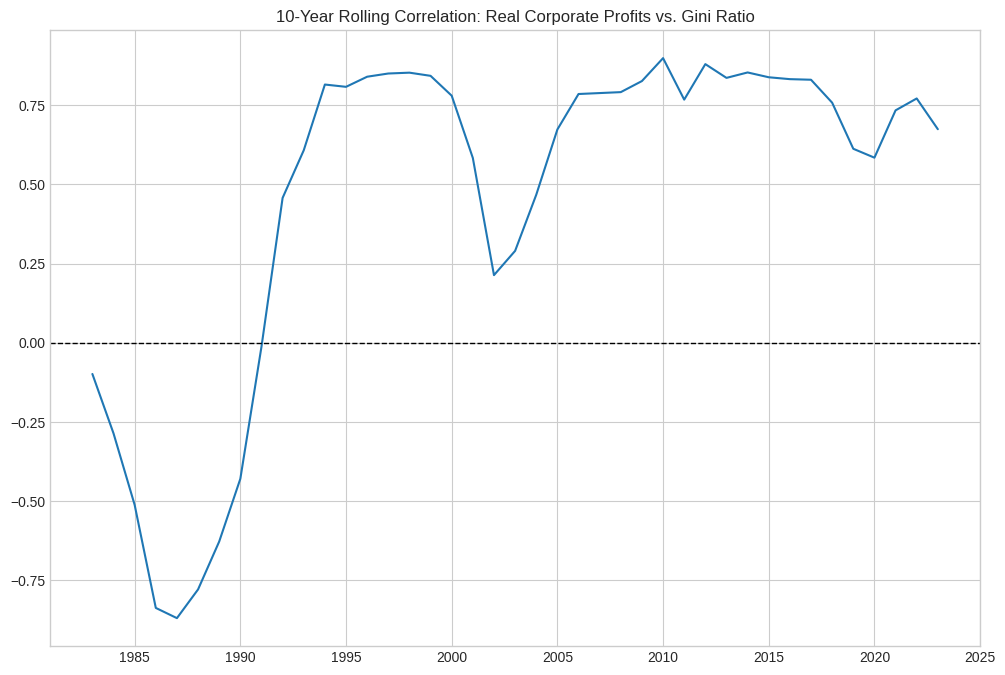


--- 5. Real Median Family Income vs. CEO Pay Ratio ---


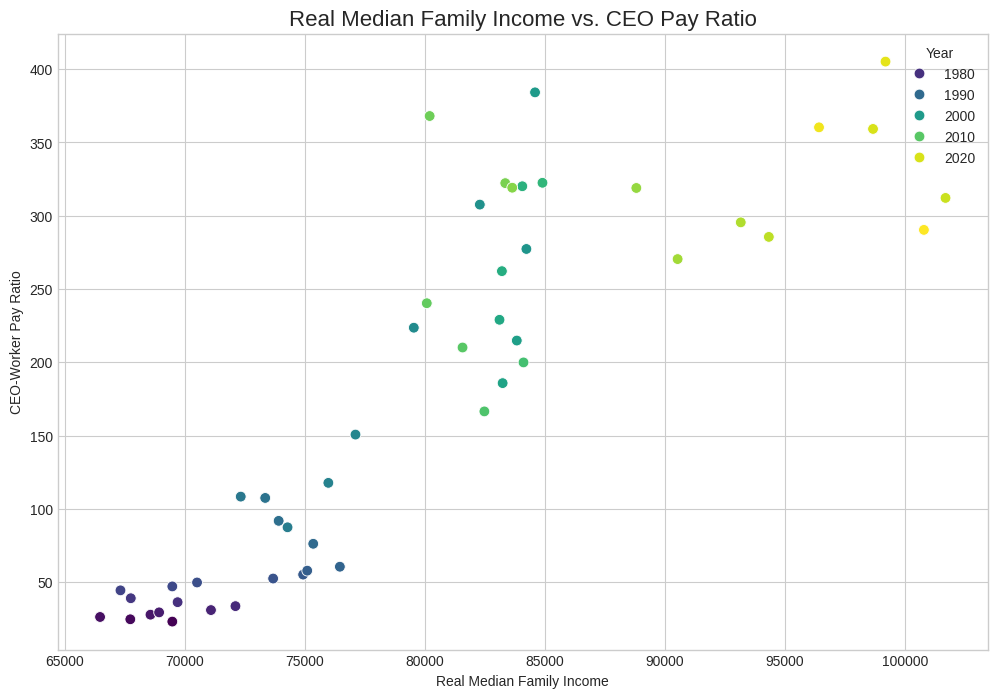

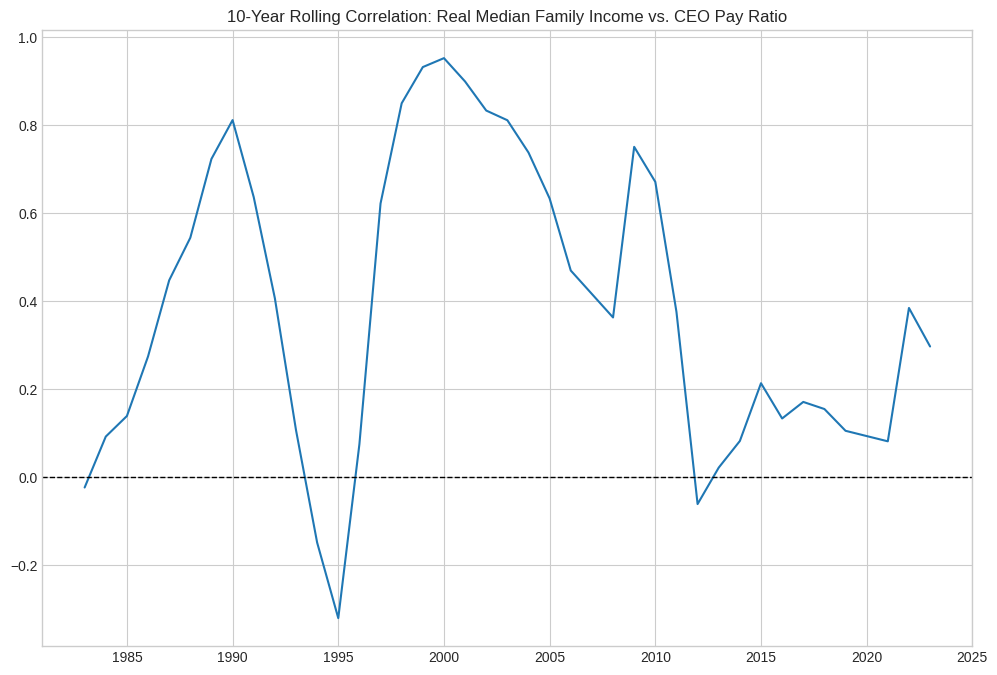


--- 6. Union Density vs. Real Median Family Income ---


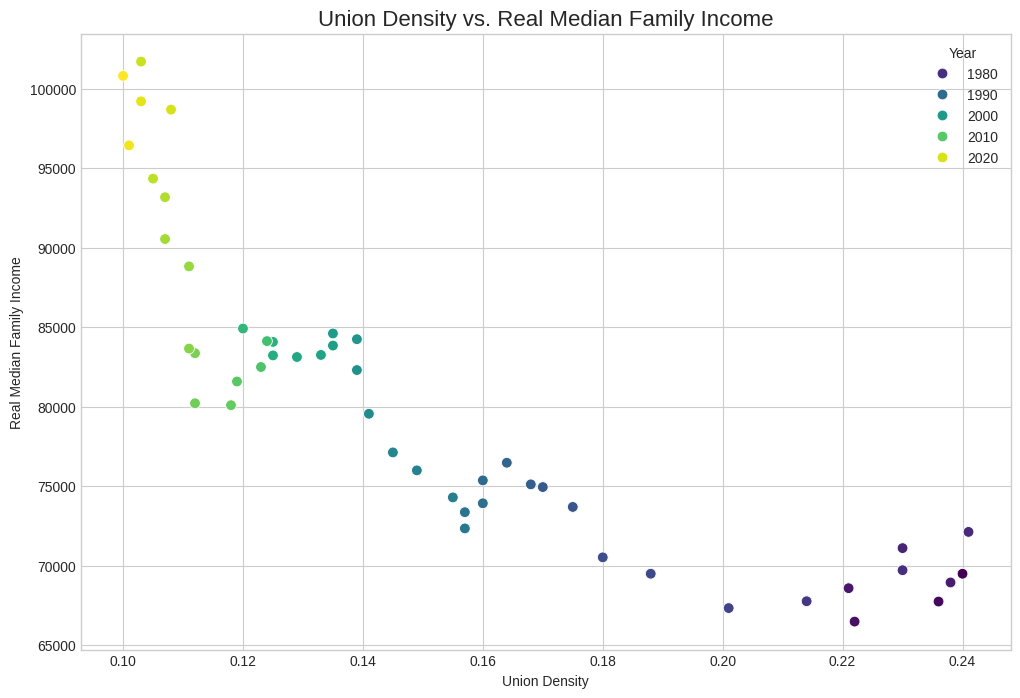

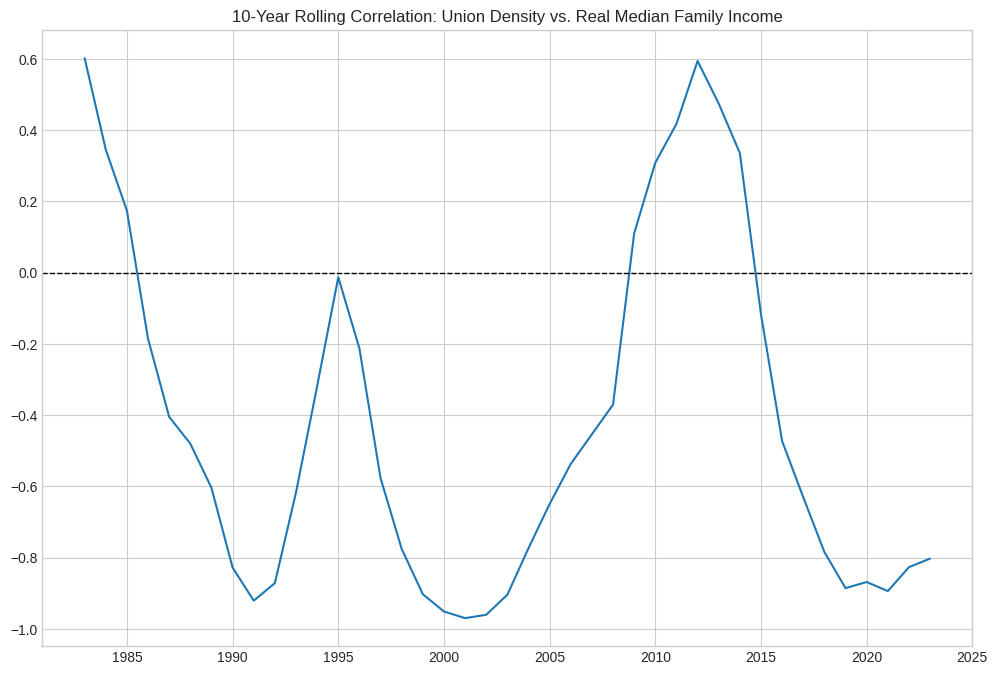


--- 7. Indexed Growth Chart ---


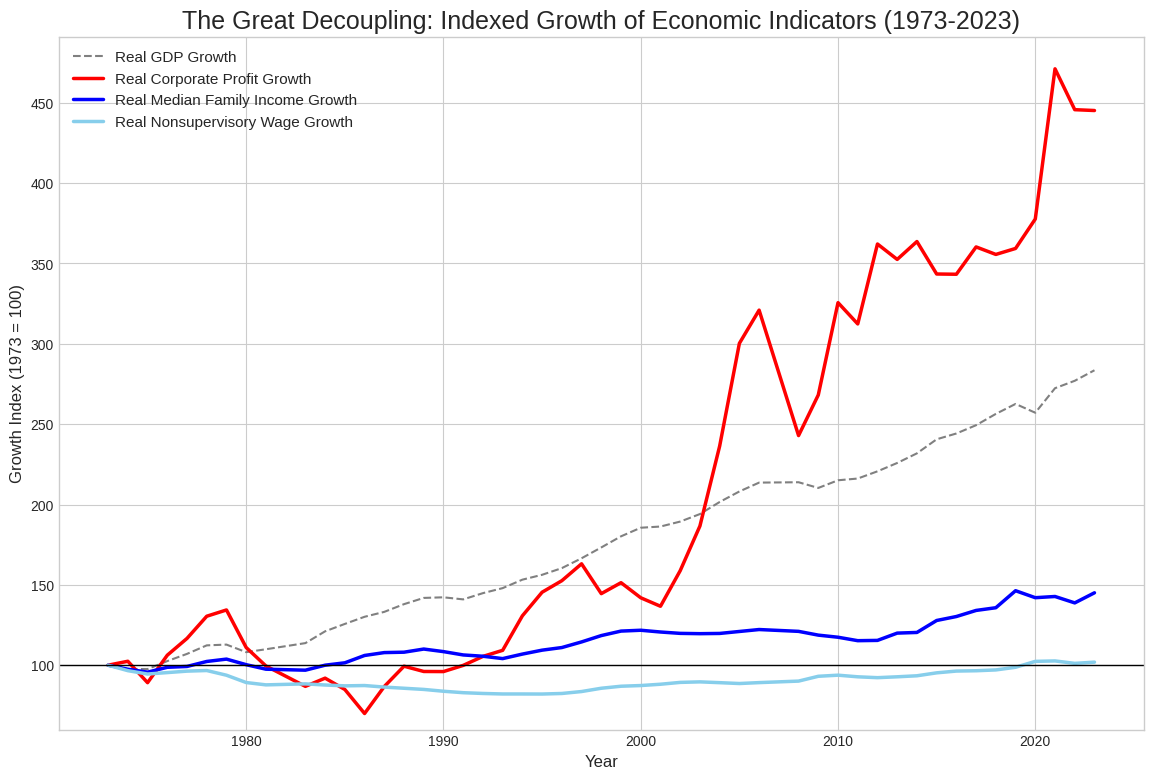


--- All Visualizations Complete ---


In [35]:
# ==============================================================================
# CELL 2: MASTER VISUALIZATION SCRIPT
# This script uses the 'plot_df' created in Cell 1 to generate all visuals.
# ==============================================================================

# Ensure 'plot_df' exists before running. If you are starting a new session,
# you must run the Data Preparation Script (Cell 1) first.

print("--- Generating All 12 Final Visualizations ---")

# Convert index to integer for clean plot labels
plot_df.index = plot_df.index.astype(int)

# 1. Correlation Heatmap
print("\n--- 1. Correlation Heatmap ---")
correlation_matrix = plot_df.corr()
plt.figure(figsize=(14, 11))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Key Economic Indicators', fontsize=16)
plt.show()

# 2. Union Density vs. CEO Pay Ratio
print("\n--- 2. Union Density vs. CEO Pay Ratio ---")
plt.figure(figsize=(12, 8))
sns.scatterplot(data=plot_df, x='Union Density', y='CEO-Worker Pay Ratio', hue=plot_df.index, palette='viridis', s=60)
plt.title('Union Density vs. CEO-Worker Pay Ratio', fontsize=16)
plt.legend(title='Year')
plt.grid(True)
plt.show()
rolling_corr = plot_df['Union Density'].rolling(window=10).corr(plot_df['CEO-Worker Pay Ratio'])
plt.figure(figsize=(12, 8))
rolling_corr.plot(title='10-Year Rolling Correlation: Union Density vs. CEO Pay Ratio')
plt.axhline(0, color='black', linewidth=1, linestyle='--'); plt.grid(True)
plt.show()

# 3. GDP vs. Corporate Profits
print("\n--- 3. Real Gdp vs. Real Corporate Profits ---")
plt.figure(figsize=(12, 8))
sns.scatterplot(data=plot_df, x='Real Gdp', y='Real Corporate Profits', hue=plot_df.index, palette='viridis', s=60)
plt.title('Real GDP vs. Real Corporate Profits', fontsize=16)
plt.legend(title='Year')
plt.grid(True)
plt.show()
rolling_corr = plot_df['Real Gdp'].rolling(window=10).corr(plot_df['Real Corporate Profits'])
plt.figure(figsize=(12, 8))
rolling_corr.plot(title='10-Year Rolling Correlation: Real GDP vs. Real Corporate Profits')
plt.axhline(0, color='black', linewidth=1, linestyle='--'); plt.grid(True)
plt.show()

# 4. Gini Ratio vs. Corporate Profits
print("\n--- 4. Gini Ratio vs. Real Corporate Profits ---")
plt.figure(figsize=(12, 8))
sns.scatterplot(data=plot_df, x='Real Corporate Profits', y='Gini Ratio', hue=plot_df.index, palette='viridis', s=60)
plt.title('Real Corporate Profits vs. Gini Ratio', fontsize=16)
plt.legend(title='Year')
plt.grid(True)
plt.show()
rolling_corr = plot_df['Real Corporate Profits'].rolling(window=10).corr(plot_df['Gini Ratio'])
plt.figure(figsize=(12, 8))
rolling_corr.plot(title='10-Year Rolling Correlation: Real Corporate Profits vs. Gini Ratio')
plt.axhline(0, color='black', linewidth=1, linestyle='--'); plt.grid(True)
plt.show()

# 5. Median Family Income vs. CEO Pay Ratio
print("\n--- 5. Real Median Family Income vs. CEO Pay Ratio ---")
plt.figure(figsize=(12, 8))
sns.scatterplot(data=plot_df, x='Real Median Family Income', y='CEO-Worker Pay Ratio', hue=plot_df.index, palette='viridis', s=60)
plt.title('Real Median Family Income vs. CEO Pay Ratio', fontsize=16)
plt.legend(title='Year')
plt.grid(True)
plt.show()
rolling_corr = plot_df['Real Median Family Income'].rolling(window=10).corr(plot_df['CEO-Worker Pay Ratio'])
plt.figure(figsize=(12, 8))
rolling_corr.plot(title='10-Year Rolling Correlation: Real Median Family Income vs. CEO Pay Ratio')
plt.axhline(0, color='black', linewidth=1, linestyle='--'); plt.grid(True)
plt.show()

# 6. Union Density vs. Median Family Income
print("\n--- 6. Union Density vs. Real Median Family Income ---")
plt.figure(figsize=(12, 8))
sns.scatterplot(data=plot_df, x='Union Density', y='Real Median Family Income', hue=plot_df.index, palette='viridis', s=60)
plt.title('Union Density vs. Real Median Family Income', fontsize=16)
plt.legend(title='Year')
plt.grid(True)
plt.show()
rolling_corr = plot_df['Union Density'].rolling(window=10).corr(plot_df['Real Median Family Income'])
plt.figure(figsize=(12, 8))
rolling_corr.plot(title='10-Year Rolling Correlation: Union Density vs. Real Median Family Income')
plt.axhline(0, color='black', linewidth=1, linestyle='--'); plt.grid(True)
plt.show()

# 7. Indexed Growth Chart
print("\n--- 7. Indexed Growth Chart ---")
columns_to_index = ['Real Gdp', 'Real Corporate Profits', 'Real Median Family Income', 'Real Nonsupervisory Wage']
indexed_df = plot_df[columns_to_index]
base_year = indexed_df.index.min()
indexed_plot = (indexed_df / indexed_df.loc[base_year]) * 100
plt.figure(figsize=(14, 9))
plt.plot(indexed_plot.index, indexed_plot['Real Gdp'], label='Real GDP Growth', color='gray', linestyle='--')
plt.plot(indexed_plot.index, indexed_plot['Real Corporate Profits'], label='Real Corporate Profit Growth', color='red', linewidth=2.5)
plt.plot(indexed_plot.index, indexed_plot['Real Median Family Income'], label='Real Median Family Income Growth', color='blue', linewidth=2.5)
plt.plot(indexed_plot.index, indexed_plot['Real Nonsupervisory Wage'], label='Real Nonsupervisory Wage Growth', color='skyblue', linewidth=2.5)
plt.title(f'The Great Decoupling: Indexed Growth of Economic Indicators ({base_year}-2023)', fontsize=18)
plt.xlabel('Year', fontsize=12)
plt.ylabel(f'Growth Index ({base_year} = 100)', fontsize=12)
plt.legend(fontsize=11)
plt.axhline(100, color='black', linewidth=1, linestyle='-')
plt.ylim(bottom=min(100, indexed_plot.min().min() - 10))
plt.show()

print("\n--- All Visualizations Complete ---")